## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Load camera calibration matrix

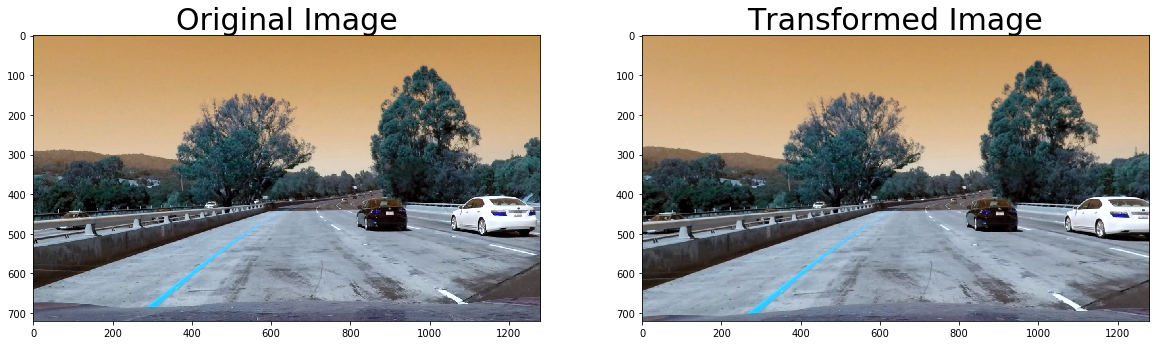

In [1]:
# Open camera distortion
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

with open('camera_cal/wide_dist_pickle.p', 'rb') as f:
    dist_pickle = pickle.load(f)
    
mtx, dist = dist_pickle["mtx"], dist_pickle["dist"]

images = glob.glob('./test_images/test*.jpg')

# Test undistortion on an image
img = cv2.imread(images[np.random.randint(0,len(images))])
img_size = (img.shape[1], img.shape[0])

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

def visualize(img, new_img):
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(new_img)
    ax2.set_title('Transformed Image', fontsize=30)

def visualize_gray(img, new_img):
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('Transformed Image', fontsize=30)

visualize(img, dst)

## Create warper function. This will only be applied later

True

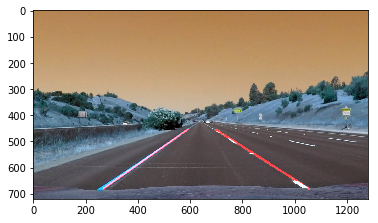

In [4]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    # Inverse matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, M, Minv

line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
persp_test = cv2.imread('test_images/straight_lines1.jpg')
# Points on the image
tl = (590, 455) #top right
tr = (img_size[0] - 582, 455) #top left
bl = (270, img_size[1] - 40) #bottom right
br = (img_size[0] - 226, img_size[1] - 40) #bottom left

cv2.line(line_img, tr, br, [255,0,0], 7)
cv2.line(line_img, tl, bl, [255,0,0], 7)
result = cv2.addWeighted(line_img, 0.8, persp_test, 1., 0.)
plt.imshow(result)
cv2.imwrite('output_images/persp_lines.jpg',result)

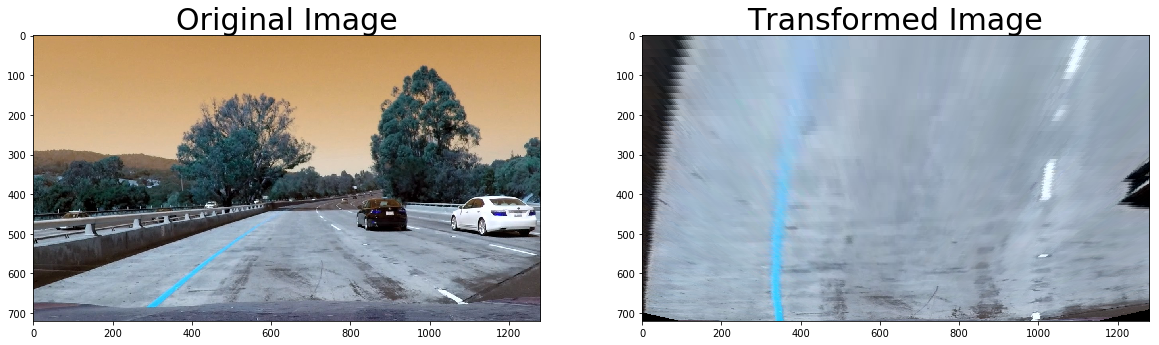

In [5]:
# For source points I'm looking at the straight line test images
# and drawing lines on the image to match lane lines
source = np.float32([tl, bl, br, tr])

# For destination points, I'm arbitrarily choosing some points to be a nice fit for displaying the warped result 
# Not exact, but close enough for our purposes. Dividing by four is a good aproximation
destination = np.float32([(img_size[0]/4, 0), (img_size[0]/4, img_size[1]), (img_size[0]*3/4, img_size[1]), (img_size[0]*3/4, 0)])

warped, M, Minv = warper(img, source, destination)
visualize(img,warped)


## Gradient thresholds and color space transforms

In [6]:
def abs_sobel_thresh(image, orient, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    else:
        raise ValueError("orient must be 'x' or 'y'")
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

In [7]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mg_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mg_sobel/np.max(mg_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

In [8]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # mg_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(gray)
    dir_binary[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

In [9]:
def color_threshold(image, s_thresh=(0,255), v_thresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) #.astype(np.float)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) #.astype(np.float)
    v_channel = hls[:,:,2]
    # Threshold color channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    color_binary = np.zeros_like(s_channel)
    color_binary[(v_binary == 1) & (s_binary == 1)] = 1    
    
    return color_binary

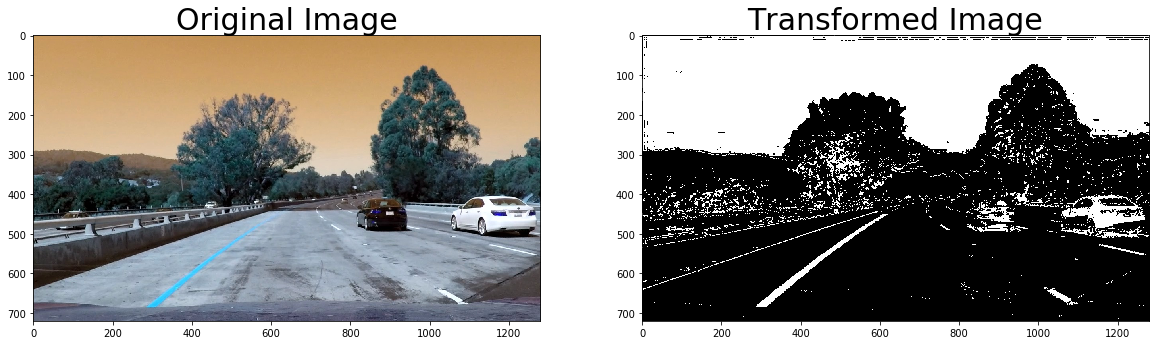

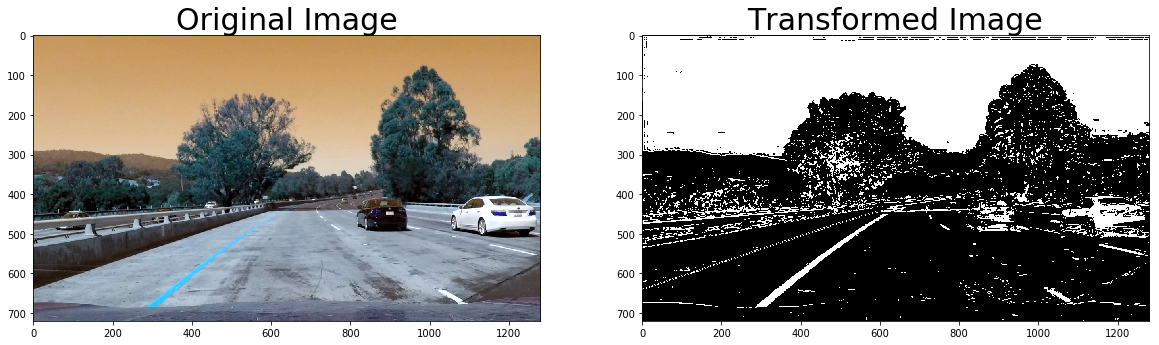

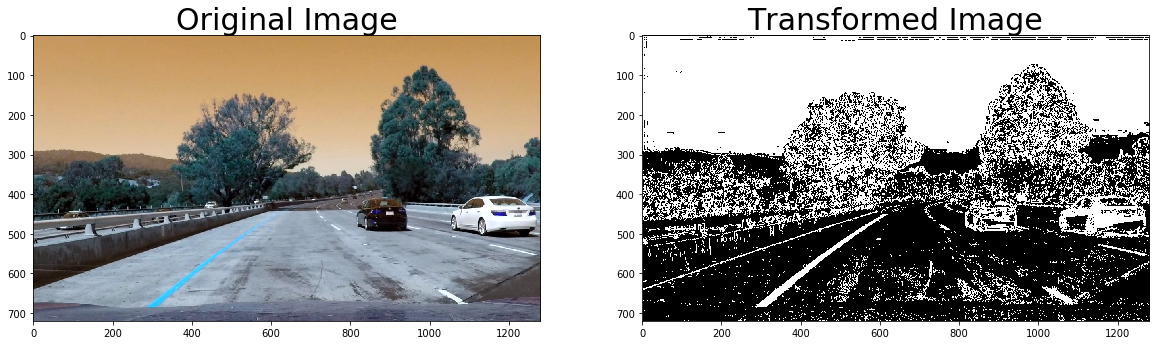

In [10]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(10, 255))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(50, 255))
mag_binary = mag_thresh(img, sobel_kernel=5, mag_thresh=(40, 100))
dir_binary = dir_threshold(img, sobel_kernel=7, thresh=(1, 2))
color_binary = color_threshold(img, s_thresh=(115,255), v_thresh=(60,255))

# Combining thresholds
combined1 = np.zeros_like(img[:,:,0])
combined1[((gradx == 1) & (grady == 1)) |  (color_binary == 1)] = 1 # ((gradx == 1) & (grady == 1)) | 
combined2 = np.zeros_like(img[:,:,0])
combined2[((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1 # ((gradx == 1) & (grady == 1)) | 
combined3 = np.zeros_like(img[:,:,0])
combined3[ (gradx == 1) | (color_binary == 1)] = 1 # ((gradx == 1) & (grady == 1)) | 

# Plotting results
visualize_gray(img, combined1)
visualize_gray(img, combined2)
visualize_gray(img, combined3)



## Process image

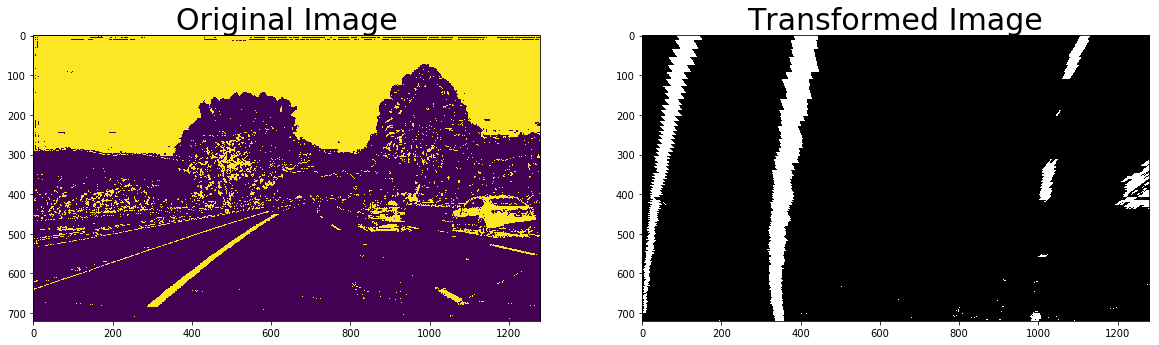

In [12]:
binary_warped = cv2.warpPerspective(combined1, M, img_size, flags=cv2.INTER_NEAREST)
visualize_gray(combined1, binary_warped)

In [13]:
# Window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [14]:
window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

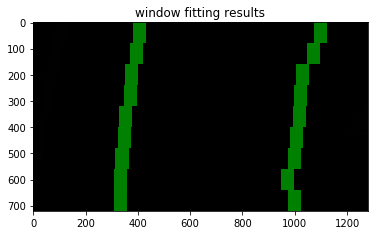

True

In [15]:
# Points used to draw all the left and right windows
l_points = np.zeros_like(binary_warped)
r_points = np.zeros_like(binary_warped)

rightx = []
leftx = []

# Go through each level and draw the windows 	
for level in range(0,len(window_centroids)):
    # Window_mask is a function to draw window areas
    l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
    r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
    
    leftx.append(window_centroids[level][0])
    rightx.append(window_centroids[level][1])
    # Add graphic points from window mask here to total pixels found 
    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

# Draw the results
template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channel
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
warpage = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8) # making the original road pixels 3 color channels
output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 

plt.imshow(output)
plt.title('window fitting results')
plt.show()
cv2.imwrite('output_images/window_fit.jpg',output)

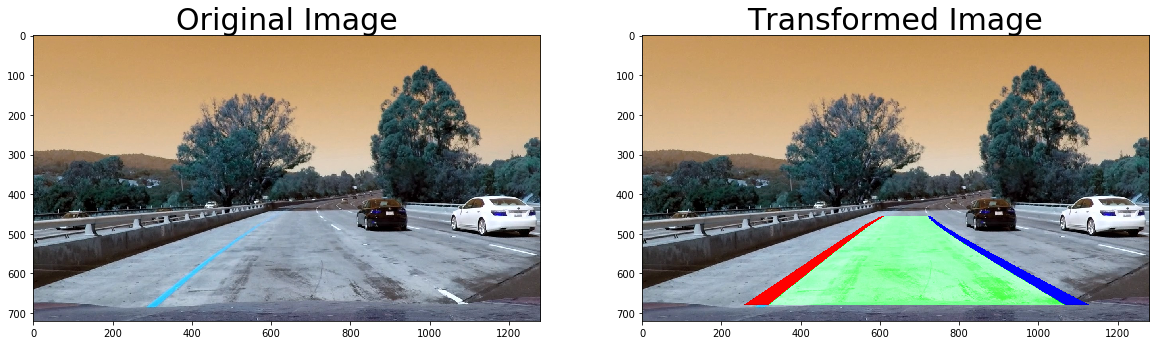

In [16]:
yvals = range(0, binary_warped.shape[0])

res_yvals = np.arange(binary_warped.shape[0] - (window_height/2), 0, -window_height)

left_fit = np.polyfit(res_yvals, leftx, 2)
left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
left_fitx = np.array(left_fitx, np.int32)

right_fit = np.polyfit(res_yvals, rightx, 2)
right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
right_fitx = np.array(right_fitx, np.int32)

left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)
inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]- window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)

road = np.zeros_like(img)
road_bkg = np.zeros_like(img)
cv2.fillPoly(road, [left_lane], color=[255,0,0])
cv2.fillPoly(road, [right_lane], color=[0,0,255])
cv2.fillPoly(road, [inner_lane], color=[0,255,0])
cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])

road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
road_bkg_warped = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)

base = cv2.addWeighted(img, 1.0, road_bkg_warped, -1.0, 0.0)
result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)

visualize(img, result)

In [17]:
ym_per_pix = 10/720
xm_per_pix = 4/384
curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.absolute(2*curve_fit_cr[0])

In [18]:
camera_center = (left_fitx[-1] + right_fitx[-1])/2
center_diff = (camera_center - result.shape[1]/2)*xm_per_pix
side_pos = 'left'
if center_diff <= 0:
    side_pos = 'right'

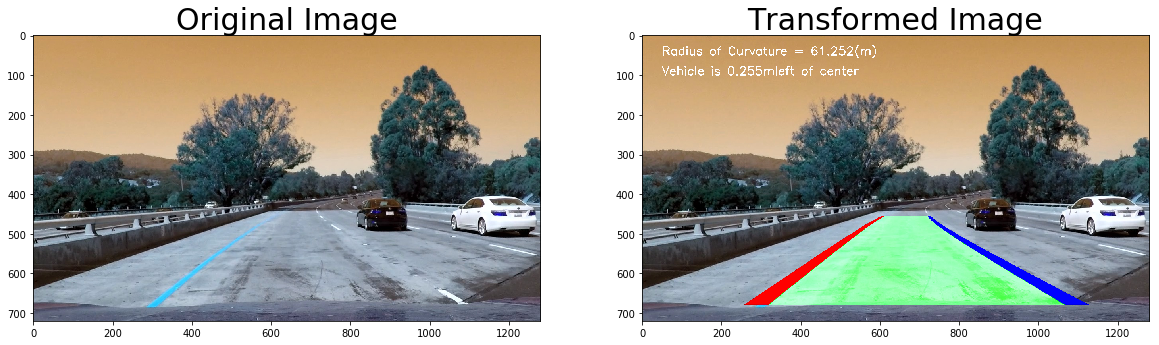

In [19]:
cv2.putText(result, 'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m'+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
visualize(img, result)

## Running pipeline over test images

In [20]:
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    img = cv2.undistort(image,mtx,dist,None, mtx)
    preprocessimg = np.zeros_like(img[:,:,0])
    preprocessimg[(gradx == 1) | (color_binary == 1)] = 1

## Pipeline

In [21]:
def process_image(image):
    img = cv2.undistort(image,mtx,dist,None, mtx)
    img_size = (img.shape[1],img.shape[0])

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(10, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(50, 255))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 120))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(1, 2))
    color_binary = color_threshold(image, s_thresh=(115,255), v_thresh=(60,255))

    # Combining thresholds
    preprocessimg = np.zeros_like(img[:,:,0])
    preprocessimg[((gradx == 1) & (grady == 1)) | (color_binary == 1)] = 1
    
    # Perspective transform
    tl = (590, 455) #top right
    tr = (img_size[0] - 582, 455) #top left
    bl = (270, img_size[1] - 40) #bottom right
    br = (img_size[0] - 226, img_size[1] - 40) #bottom left
    source = np.float32([tl, bl, br, tr])
    destination = np.float32([(img_size[0]/4, 0), (img_size[0]/4, img_size[1]), (img_size[0]*3/4, img_size[1]), (img_size[0]*3/4, 0)])
    warped, M, Minv = warper(preprocessimg, source, destination)
    
    # Window settings
    window_width = 25
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 25 # How much to slide left and right for searching
    
    # Sliding window search
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    global recent_centers
    recent_centers.append(window_centroids)
    smooth_factor = 10
    window_centroids = np.average(recent_centers[-smooth_factor:], axis=0)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)

        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        
    yvals = range(0, warped.shape[0])

    res_yvals = np.arange(warped.shape[0] - (window_height/2), 0, -window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]- window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color=[255,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,255])
    cv2.fillPoly(road, [inner_lane], color=[0,255,0])
    cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
    cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])
    
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_bkg_warped = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(img, 1.0, road_bkg_warped, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)
    
    ym_per_pix = 10/720
    xm_per_pix = 4/384
    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.absolute(2*curve_fit_cr[0])
    
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center - warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    
    cv2.putText(result, 'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m'+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return result

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

recent_centers = []
test_output = 'final_video.mp4'
clip = VideoFileClip("project_video.mp4")
# function to find lane lines   vvv
test_clip = clip.fl_image(process_image)

test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video final_video.mp4
[MoviePy] Writing video final_video.mp4


100%|█████████▉| 1256/1261 [12:17<00:02,  1.93it/s]

In [122]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>    
""".format(test_output))
# video here   ^^^